# **В этой работе выполнен анализ итоговых баллов за курс линейной алгебры студентов базовой математики университета ИТМО с точки зрения практических и лекционных потоков. Дан ответ на вопрос: есть ли существенная разница между потоками?**

In [ ]:
import pandas as pd
import seaborn as sns

df_res = pd.read_csv('baza.csv')
df_streams = pd.read_csv('streams.csv')
df_res.columns = df_res.iloc[0]
df_res = df_res.iloc[1:]
df_res = df_res.reset_index(drop=True)
df_res.columns.values[1] = "Практический поток"
df_res.columns.values[11] = "Сумма практики"
df_res.columns.values[15] = "Итог"
df_res = df_res.merge(df_streams, on='Практический поток', how='left')
df_res.head()

,ИСУ,Практический поток,ДЗ-1,ДЗ-2,ДЗ-3,КР-1,КР-2,КР-3,ТМ-1,ТМ-2,ТМ-3,Сумма практики,КЛК,ИТ,ЭКЗ,Итог,Лекционный поток
0,312389,Лин Алг 1.1,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,Лин Алг 1
1,465095,Лин Алг 1.1,8,8,8,8,8,8,4,4,4,60,9,10.0,20,99.0,Лин Алг 1
2,408201,Лин Алг 1.1,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,Лин Алг 1
3,489570,Лин Алг 1.1,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,Лин Алг 1
4,408364,Лин Алг 1.1,8,8,8,8,8,8,4,4,4,60,0,6.0,0,66.0,Лин Алг 1


# **Анализ лекционных потоков**

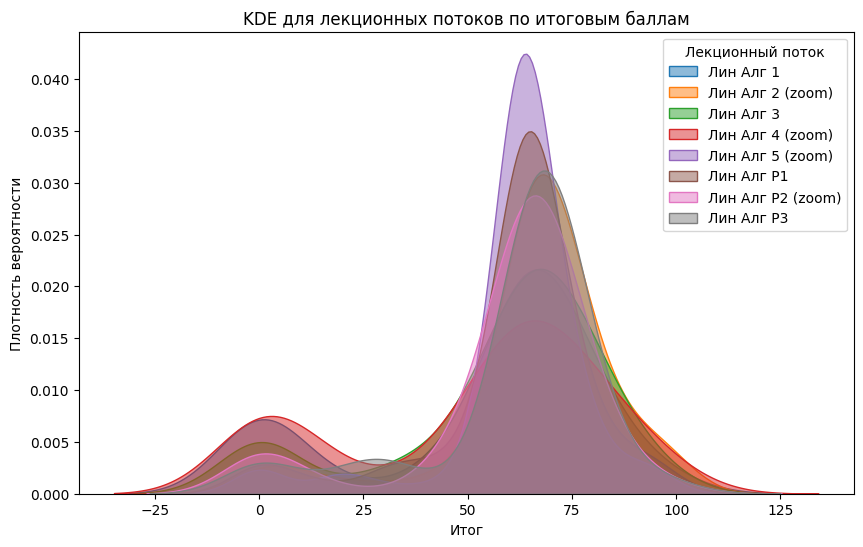

In [ ]:
import matplotlib.pyplot as plt

cols_to_convert = ["ДЗ-1", "ДЗ-2", "ДЗ-3", "КР-1", "КР-2", "КР-3", "ТМ-1", "ТМ-2", "ТМ-3", "Сумма практики", "КЛК", "ИТ", "ЭКЗ", "Итог"]
for col in cols_to_convert:
    df_res[col] = pd.to_numeric(df_res[col], errors='coerce')

plt.figure(figsize=(10, 6))
# построим KDE для каждого лекционного потока отдельно
for stream in df_res['Лекционный поток'].unique():
    subset = df_res[df_res['Лекционный поток'] == stream]
    data = subset["Итог"].dropna()
    sns.kdeplot(data, label=stream, fill=True, alpha=0.5)

plt.title('KDE для лекционных потоков по итоговым баллам')
plt.xlabel('Итог')
plt.ylabel('Плотность вероятности')
plt.legend(title='Лекционный поток')
plt.show()


### Четко видны два пика. Большой: в районе 60 баллов (необходимый минимум для аттестации) и около нуля (возможно уже отчисленные или просто студенты, которые не занимались линалом)

### **Boxplot для сравнения медианы, IQR, выбросов**

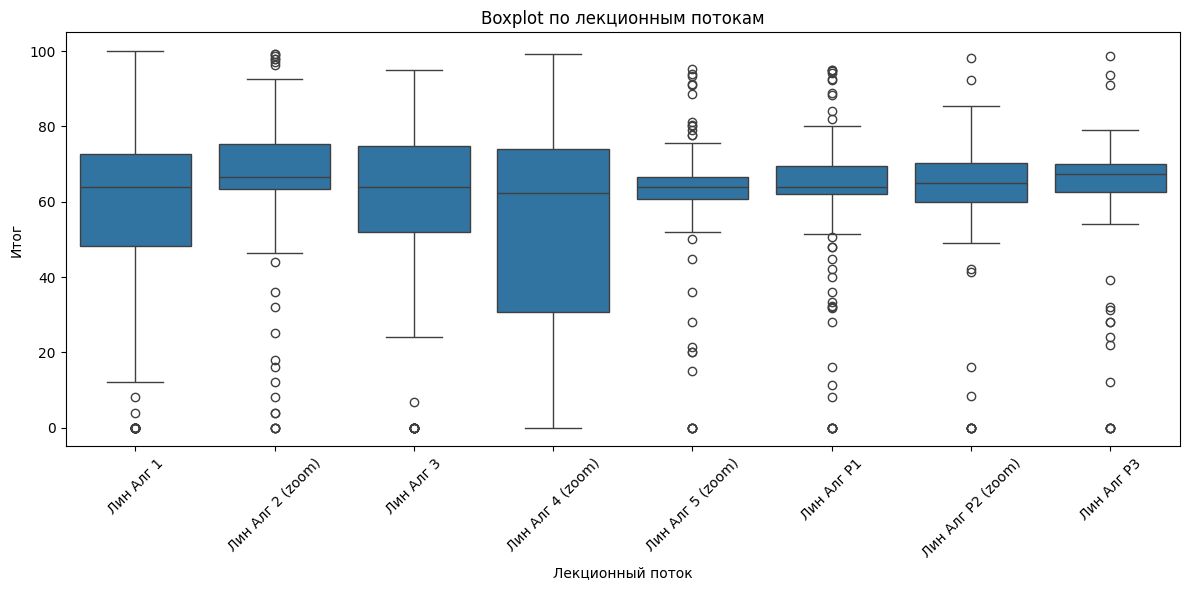

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_res, x="Лекционный поток", y="Итог")
plt.title("Boxplot по лекционным потокам")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Медианные значения во всех потоках примерно одинаковы, однако разброс баллов отличается. Так в 4 потоке данные распределены более равномерно по всей шкале оценивания, так как межквартильный размах охватывает всю шкалу

### **Описательная статистика**

In [ ]:

from scipy.stats import iqr
desc = df_res.groupby("Лекционный поток")["Итог"].agg(["count", "mean", "std", "var", "median", "min", "max", iqr])
display(desc.style.format("{:.2f}"))

,count,mean,std,var,median,min,max,iqr
Лекционный поток,,,,,,,,
Лин Алг 1,155.00,54.24,28.60,818.22,64.00,0.00,100.00,24.30
Лин Алг 2 (zoom),145.00,65.74,20.33,413.18,66.70,0.00,99.30,12.00
Лин Алг 3,111.00,57.96,25.73,662.18,64.00,0.00,95.00,22.90
Лин Алг 4 (zoom),124.00,52.25,30.44,926.73,62.35,0.00,99.30,43.28
Лин Алг 5 (zoom),138.00,61.85,16.95,287.35,64.00,0.00,95.30,6.00
Лин Алг P1,138.00,61.26,19.30,372.51,64.00,0.00,95.00,7.53
Лин Алг P2 (zoom),79.00,60.19,21.60,466.39,65.00,0.00,98.30,10.20
Лин Алг P3,84.00,61.39,21.26,451.89,67.30,0.00,98.70,7.55


### Нестабильность в оценивании студентов 4 потока подтверждается статистически. Необходимо скорректировать программу.

### По данным видно, что не везде у студентов одинаковые условия обучения. Отличаются межквартильные размахи. В каких-то потоках среднее сильно отклоняется вниз от медианы, что говорит о большом количестве учеников, набирающих 0 или такие же баллы. Где-то наоборот среднее примерно равно медианному.

## **Проверка различий между потоками**

### **ANOVA**

In [ ]:
from scipy.stats import f_oneway

# группируем по лекционным потокам и собираем итоговые баллы
groups = [group["Итог"].dropna() for name, group in df_res.groupby("Лекционный поток")]

# выполняем однофакторный дисперсионный анализ
f_stat, p_val = f_oneway(*groups)

print(f"ANOVA: F-статистика = {f_stat:.3f}, p-значение = {p_val:.5f}")

alpha = 0.05
if p_val < alpha:
    print("Результат статистически значим: различия между лекционными потоками есть.")
else:
    print("Нет статистически значимых различий между лекционными потоками.")


ANOVA: F-статистика = 4.679, p-значение = 0.00004
Результат статистически значим: различия между лекционными потоками есть.


### Гипотезы выдвигаемые ранее подтвердились.

### Потоки не равны. Это значит, что:

### 1) при разных разбросах невозможно объективно оценить способность лекторов преподавать материал

### 2) Собирать статистику общую может быть некорректно

### 3) В, например, потоке P1 проще получить удовлетворительно, чем в потоке 4

## **Tukey HSD**

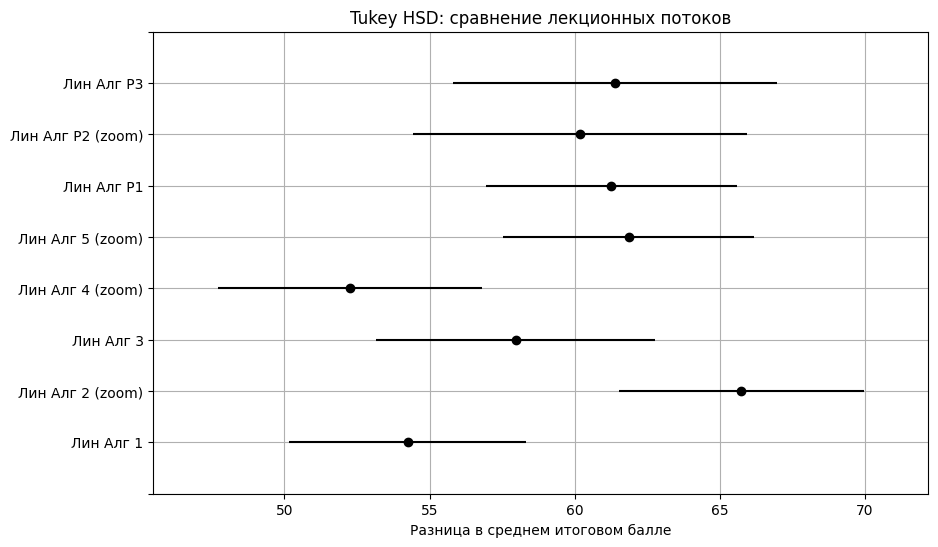

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# создаём выборки
data = df_res[["Итог", "Лекционный поток"]].dropna()

# Tukey HSD
tukey = pairwise_tukeyhsd(endog=data["Итог"], groups=data["Лекционный поток"], alpha=0.05)
tukey.plot_simultaneous(figsize=(10, 6))
plt.title("Tukey HSD: сравнение лекционных потоков")
plt.xlabel("Разница в среднем итоговом балле")
plt.grid(True)
plt.show()


### Видим разницу в средних баллах между потоками. Осталось узнать, как именно складываются суммарные баллы в потоках:

Tukey HSD по компоненте: ДЗ-1


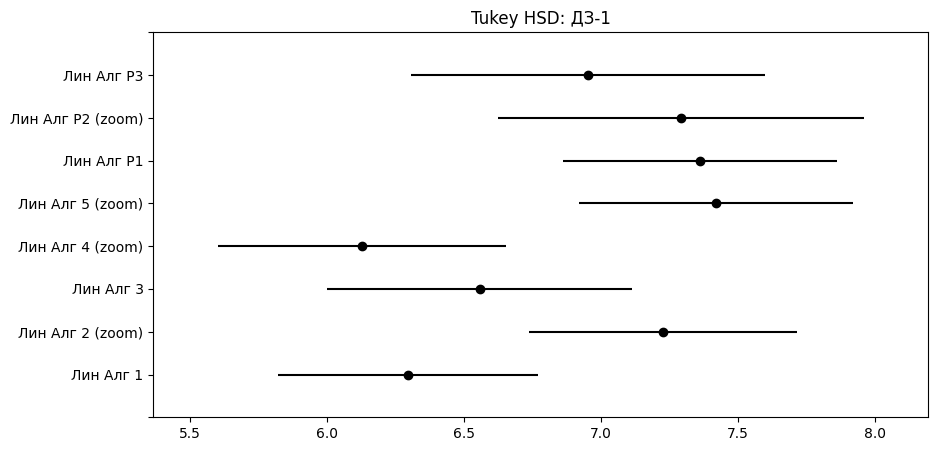

Tukey HSD по компоненте: ДЗ-2


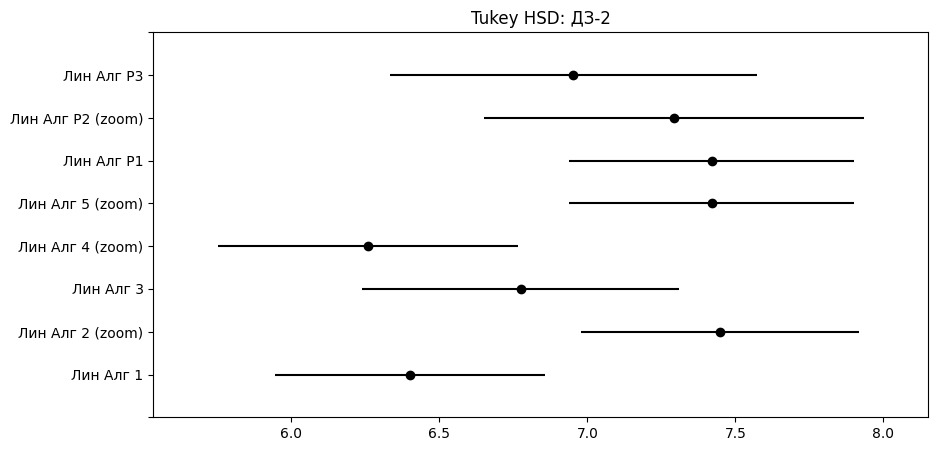

Tukey HSD по компоненте: ДЗ-3


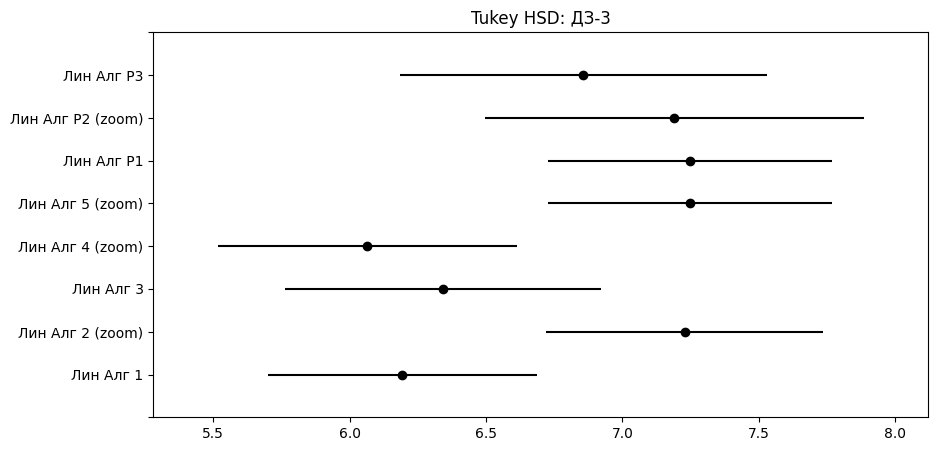

Tukey HSD по компоненте: КР-1


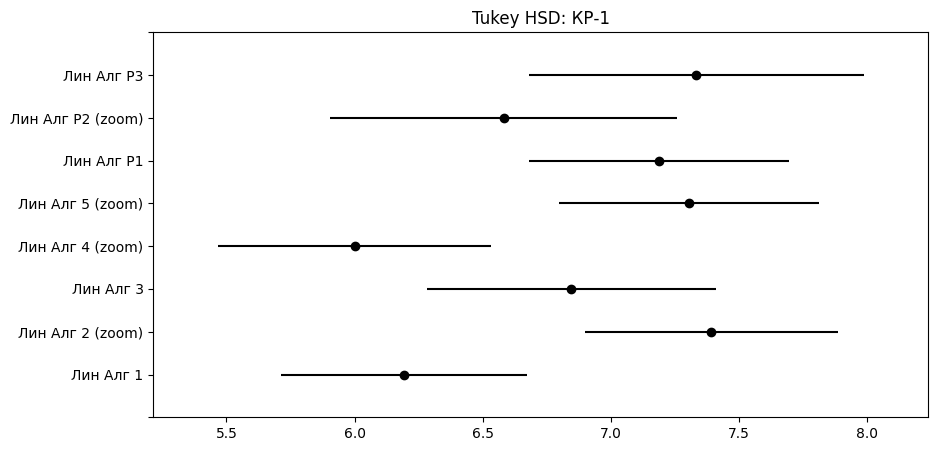

Tukey HSD по компоненте: КР-2


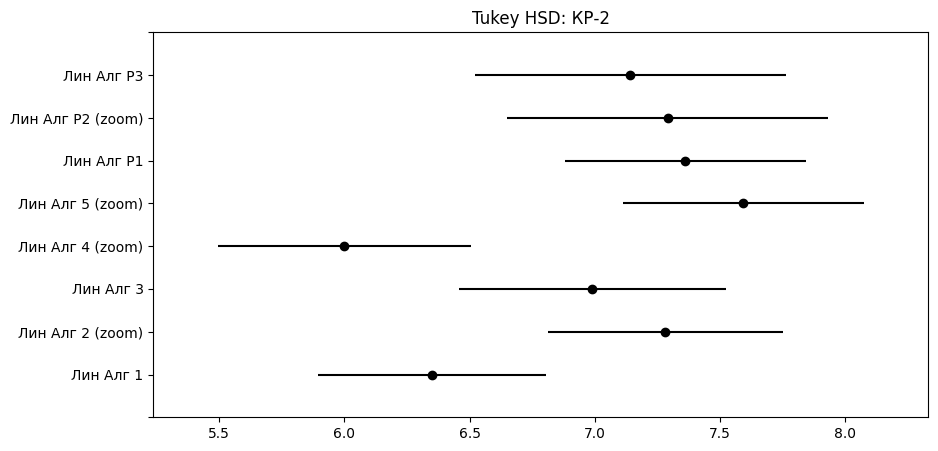

Tukey HSD по компоненте: КР-3


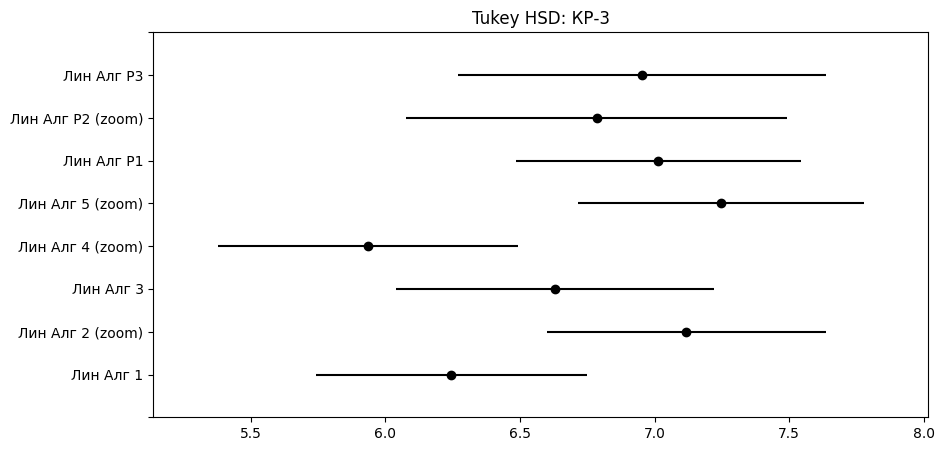

Tukey HSD по компоненте: ТМ-1


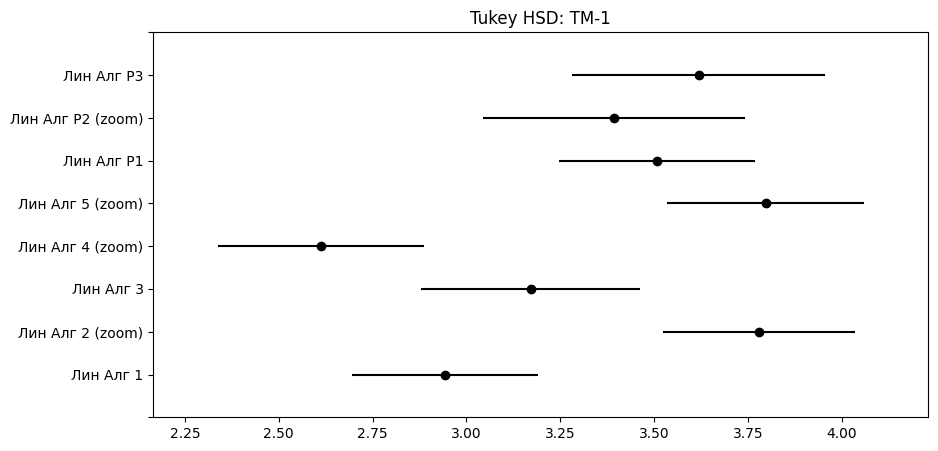

Tukey HSD по компоненте: ТМ-2


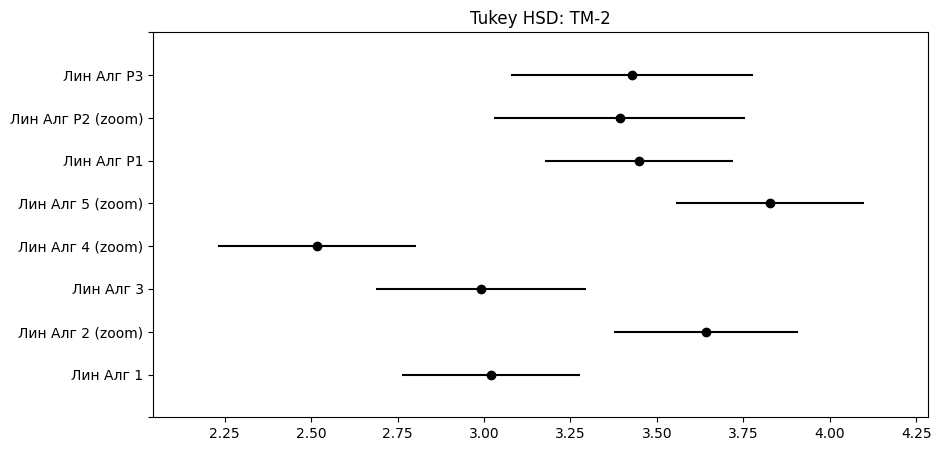

Tukey HSD по компоненте: ТМ-3


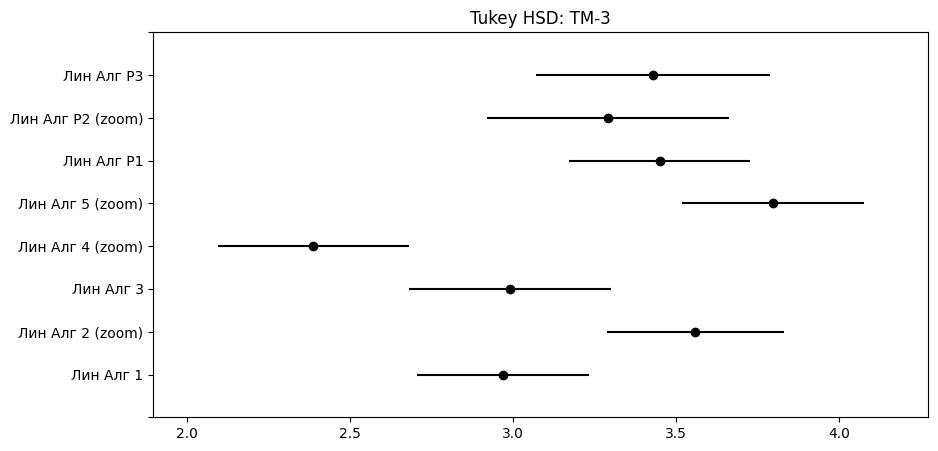

Tukey HSD по компоненте: Сумма практики


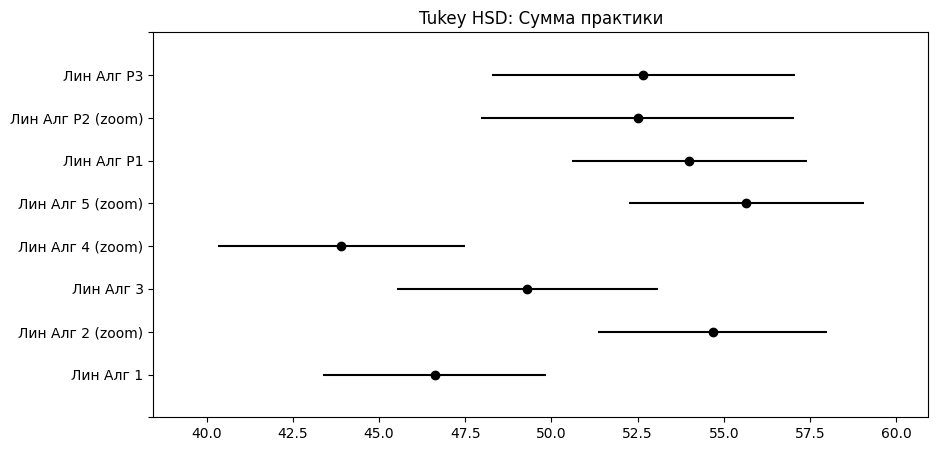

Tukey HSD по компоненте: КЛК


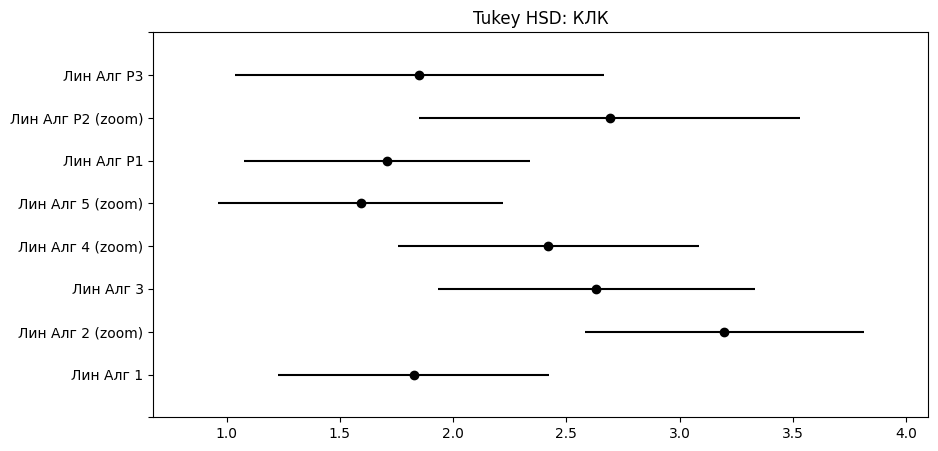

Tukey HSD по компоненте: ИТ


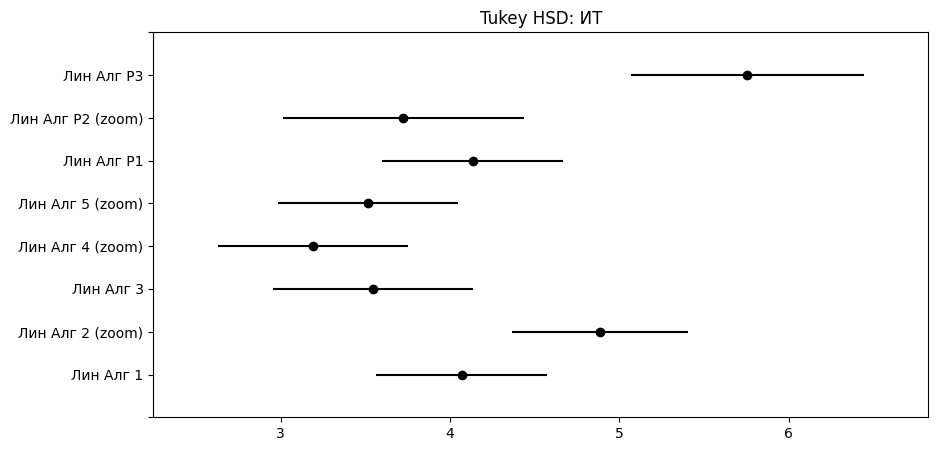

Tukey HSD по компоненте: ЭКЗ


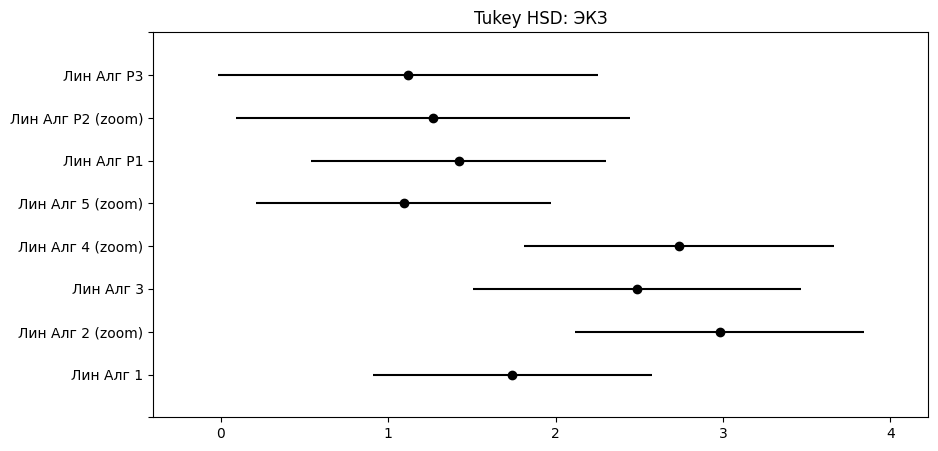

In [ ]:
components = ["ДЗ-1", "ДЗ-2", "ДЗ-3", "КР-1", "КР-2", "КР-3", "ТМ-1", "ТМ-2", "ТМ-3", "Сумма практики", "КЛК", "ИТ", "ЭКЗ"]

for col in components:
    tukey = pairwise_tukeyhsd(endog=df_res[col], groups=df_res["Лекционный поток"], alpha=0.05)
    print(f"Tukey HSD по компоненте: {col}")
    tukey.plot_simultaneous(figsize=(10, 5))
    plt.title(f"Tukey HSD: {col}")
    plt.show()


### Интересные результаты. Раз уж затронули ранее 4 поток, поговорим отдельно про него. Видно невооруженным взглядом, что за КР, ДЗ и ТМ там студенты получают сильно меньше баллов. Это говорит либо о неравной сложности задании, либо о неодинаковом оценивании студенческих работ, либо об объективном отставании студентов (возможно, обусловлено зумом)

### Интересно, что баллы за экзамен и КЛК в 4 потоке больше, чем в других группах. Возможно можно это объяснить тем, что по результатам практик студентам не хватает баллов до порога, а значит присутствует мотивация хорошо сдать экзамен больше.

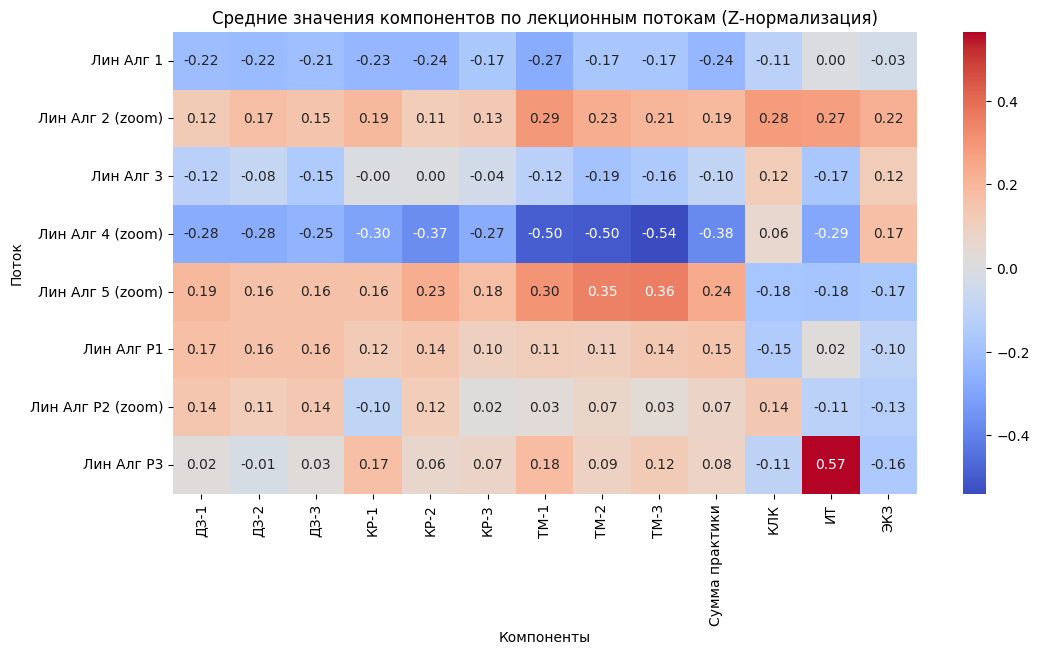

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_res[components] = scaler.fit_transform(df_res[components])

pivot = df_res.groupby("Лекционный поток")[components].mean()

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="coolwarm")

plt.title("Средние значения компонентов по лекционным потокам (Z-нормализация)")
plt.xlabel("Компоненты")
plt.ylabel("Поток")
plt.show()


### Тут тоже 4 поток выделяется глубокими синими цветами - поток получает сильно меньше баллов по большинству точек.

### Так же особенно выделяется поток P3 на ИТ. Чем обусловлена такая корреляция, тоже неизвестно, но этому стоит уделить внимание.

# **Анализ практических потоков**

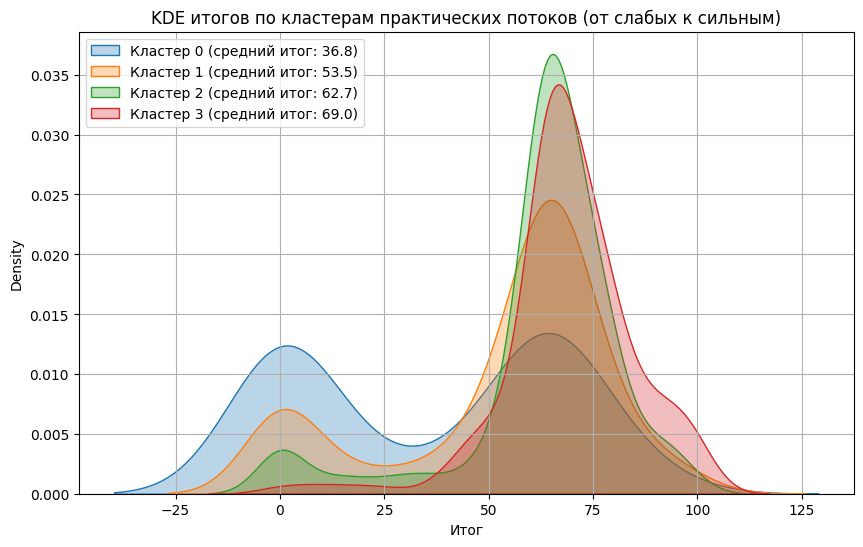

,Практический поток,Итог,Кластер
3,Лин Алг 1.4,42.985714,0
31,Лин Алг R 3.2,35.300000,0
11,Лин Алг 4.4,31.974194,0
20,Лин Алг P1.5,57.630000,1
25,Лин Алг P3.2,56.838462,1
0,Лин Алг 1.1,56.271875,1
18,Лин Алг P1.3,53.771429,1
8,Лин Алг 4.1,52.684375,1
2,Лин Алг 1.3,51.554545,1
23,Лин Алг P2.3,49.640741,1


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# группируем по практическим потокам
means = df_res.groupby("Практический поток")["Итог"].mean().reset_index()

# кластеризуем по итоговому значению
kmeans = KMeans(n_clusters=4, random_state=42)
means["Кластер"] = kmeans.fit_predict(means[["Итог"]])

# считаем средний итог по кластерам, сортируем их по возрастанию
order = means.groupby("Кластер")["Итог"].mean().sort_values().index

# создаем словарь для перенумерации кластеров по возрастанию итогов
mapping = {old_label: new_label for new_label, old_label in enumerate(order)}

# применяем перенумерацию
means["Кластер"] = means["Кластер"].map(mapping)

df_res = df_res.drop(columns=["Кластер"], errors='ignore')
df_res = df_res.merge(means[["Практический поток", "Кластер"]], on="Практический поток")

plt.figure(figsize=(10,6))
for cl in sorted(df_res["Кластер"].unique()):
    sns.kdeplot(df_res[df_res["Кластер"] == cl]["Итог"], label=f"Кластер {cl} (средний итог: {means[means['Кластер']==cl]['Итог'].mean():.1f})", fill=True, alpha=0.3)

plt.title("KDE итогов по кластерам практических потоков (от слабых к сильным)")
plt.xlabel("Итог")
plt.legend()
plt.grid(True)
plt.show()

# сортированный вывод средних итогов по кластерам
means_sorted = means.sort_values(["Кластер", "Итог"], ascending=[True, False])
display(means_sorted)


### Необходимо уделить внимание потокам, попавшим в 0 кластер. Балл является очень низким. Также необходимо изучить кластер 3 и узнать, чем обусловлены такие баллы: "недушной" проверкой или методиками, которые можно масштабировать

### **Отличие практических потоков внутри одного лекционного потока**

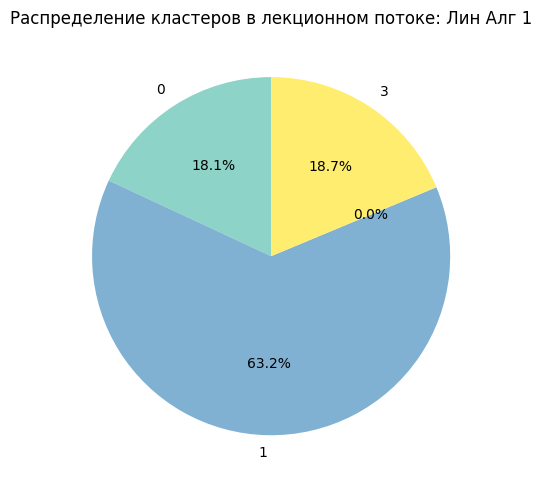

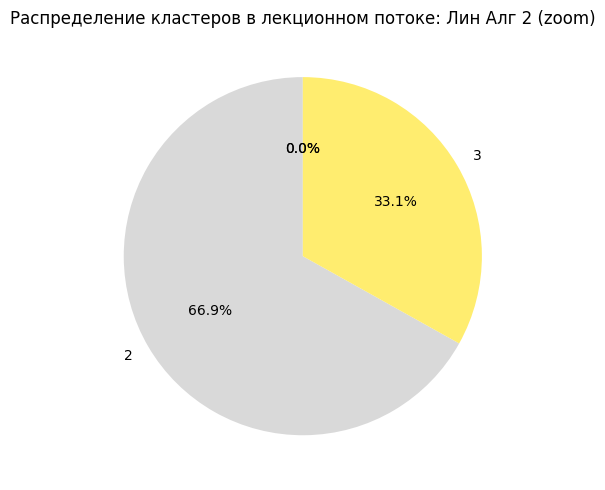

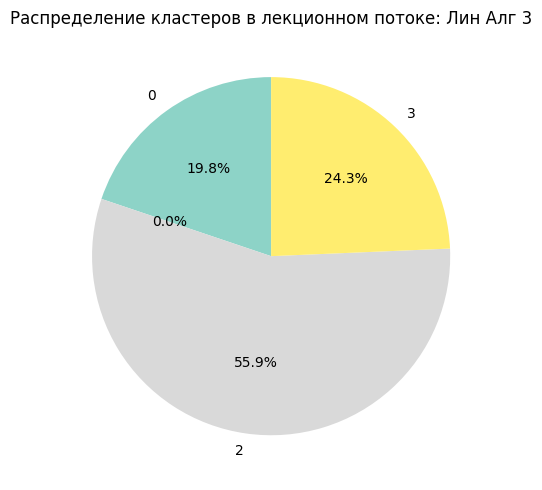

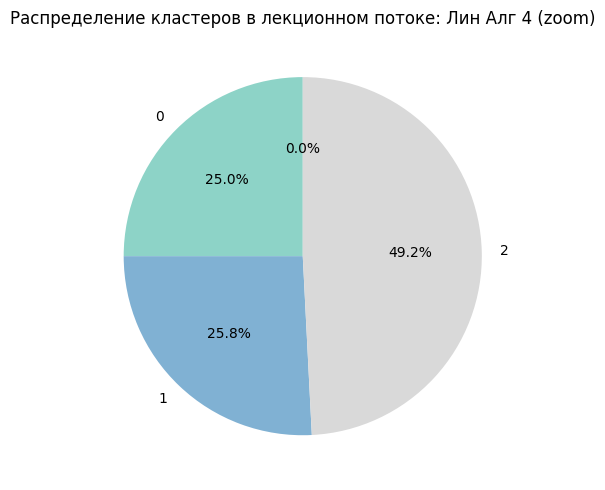

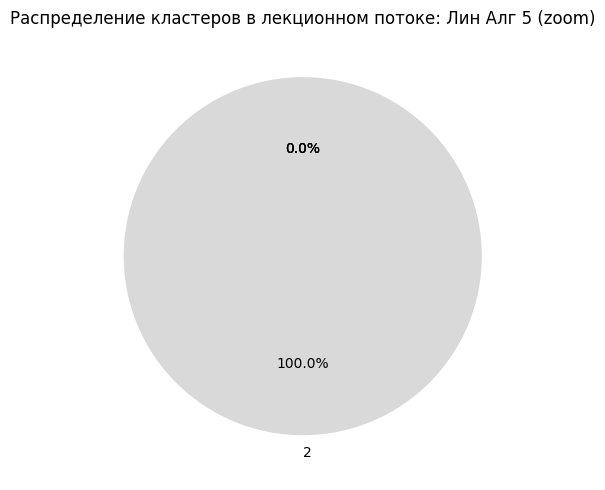

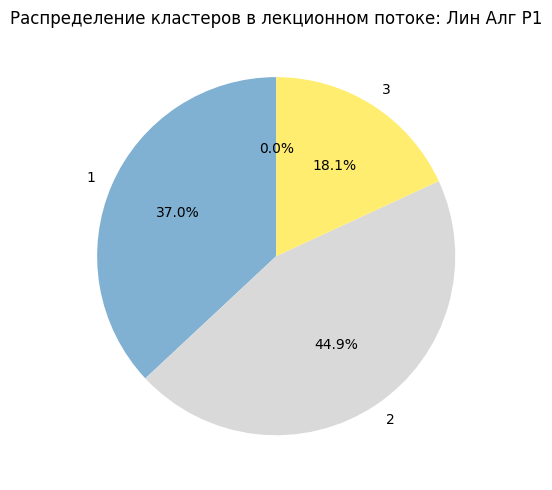

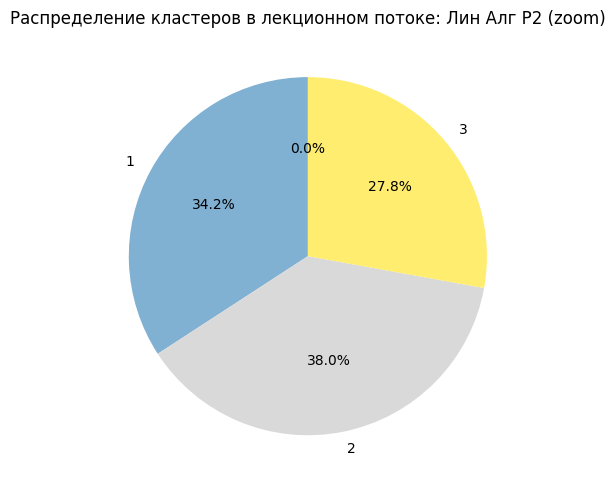

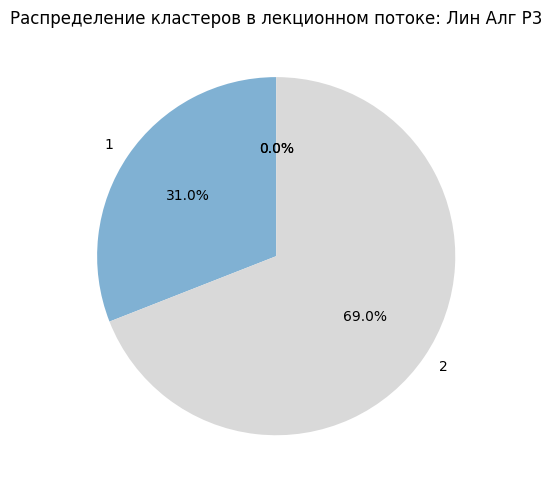

In [ ]:
cluster_counts = df_res.groupby(["Лекционный поток", "Кластер"]).size().unstack(fill_value=0)

# строим pie chart по каждому лекционному потоку
for lec in cluster_counts.index:
    plt.figure(figsize=(5,5))
    cluster_counts.loc[lec].plot.pie(
        autopct='%1.1f%%',
        startangle=90,
        colormap="Set3",
        title=f"Распределение кластеров в лекционном потоке: {lec}",
        ylabel=""
    )
    plt.tight_layout()
    plt.show()

### **Описательная статистика**

In [ ]:
df_res = df_res.drop(columns=["Кластер"])

from scipy.stats import iqr
desc = df_res.groupby("Практический поток")["Итог"].agg(["count", "mean", "std", "var", "median", "min", "max", iqr])
display(desc.style.format("{:.2f}"))


,count,mean,std,var,median,min,max,iqr
Практический поток,,,,,,,,
Лин Алг 1.1,32.00,56.27,30.58,935.09,65.35,0.00,99.00,28.27
Лин Алг 1.2,29.00,71.66,14.23,202.63,74.30,16.00,100.00,12.60
Лин Алг 1.3,33.00,51.55,30.75,945.44,64.00,0.00,92.30,24.70
Лин Алг 1.4,28.00,42.99,30.34,920.49,61.30,0.00,89.30,64.70
Лин Алг 1.5,33.00,49.21,26.62,708.86,62.30,0.00,75.70,18.70
Лин Алг 2.4,30.00,60.47,26.21,687.22,67.65,0.00,98.00,7.75
Лин Алг 2.5,37.00,65.08,15.07,226.99,66.30,0.00,85.30,11.00
Лин Алг 3.4,35.00,59.43,25.54,652.41,63.30,0.00,93.30,24.30
Лин Алг 4.1,32.00,52.68,25.95,673.62,62.85,0.00,87.70,18.00


### Есть сильные различия между множеством потоков. Возможно, это обусловлено градацией студентов по силе в практические потоки.

### **Визуализация**

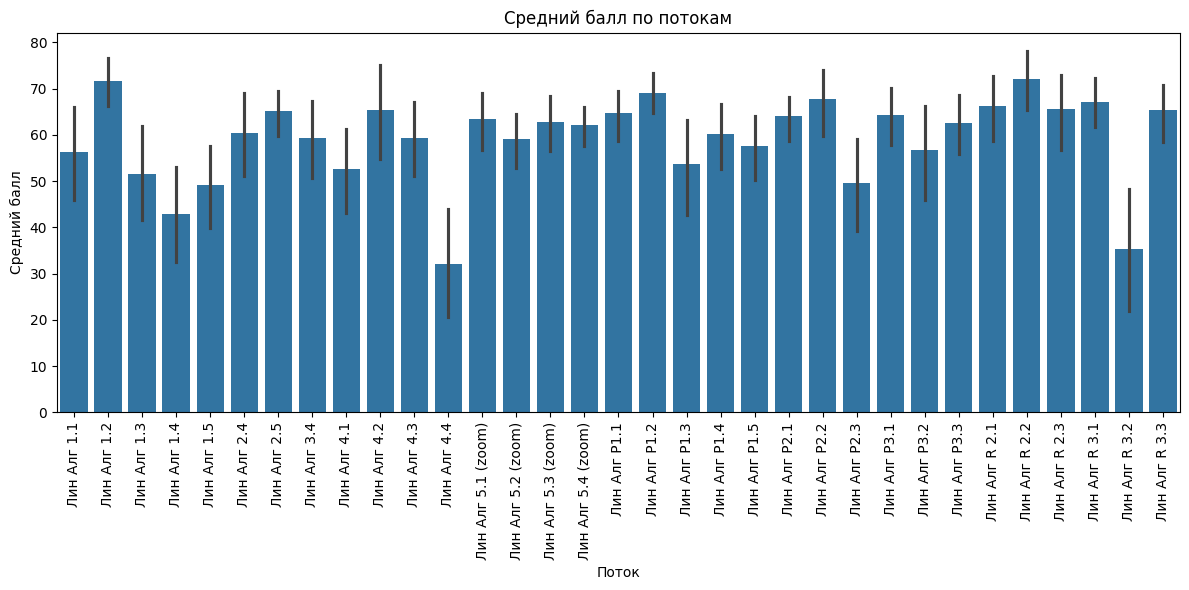

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data = df_res, x = 'Практический поток', y = 'Итог')
plt.title("Средний балл по потокам")
plt.xlabel("Поток")
plt.ylabel("Средний балл")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Особенно негативно выделяются потоки 4.4, R 3.2. Необходимо отдельно выяснить, почему результаты в этих практических потоках настолько низкие.

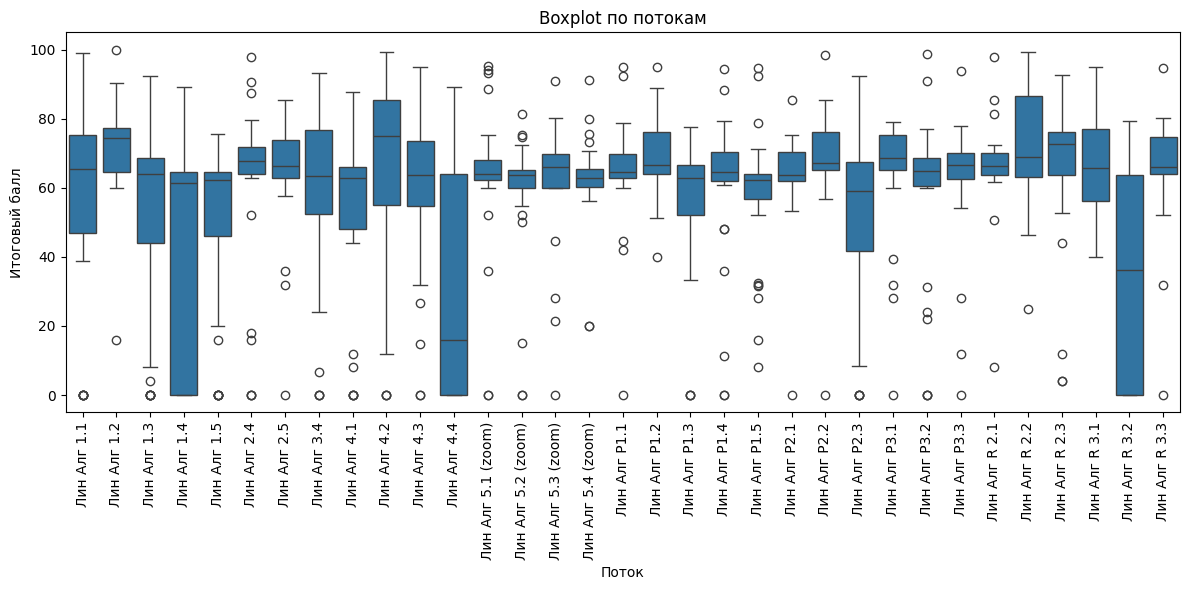

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data = df_res, x = 'Практический поток', y = 'Итог')
plt.title("Boxplot по потокам")
plt.xlabel("Поток")
plt.ylabel("Итоговый балл")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### **Видны сильные отличия между потоками. Разбросы между баллами очень сильно отличаются в различных потоках.**

### **Лин Алг 1.4**: Ящик расположен очень низко, медиана около 20-30 баллов, что крайне низко. Ус практически отсутствует, указывая на то, что большинство студентов в этом потоке получили очень низкие оценки. Есть несколько выбросов с более высокими баллами. Этот поток является одним из самых слабых.

### **Лин Алг 4.4**: Аналогично "Лин Алг 1.5", ящик и медиана очень низкие (около 20-30 баллов). Это подтверждает выводы из предыдущих графиков о проблемах в потоках "Лин Алг 4 (zoom)".

### **Лин Алг R 3.2:** Медиана также очень низка (около 20-30 баллов), что указывает на серьезные проблемы с успеваемостью в этом потоке.

###**Что и было замечено ранее, есть проблемные потоки.**

### **ANOVA**

In [ ]:
from scipy.stats import f_oneway

# список итогов по каждому потоку
groups = [group["Итог"].dropna().values for name, group in df_res.groupby("Практический поток")]

# однофакторный дисперсионный анализ
f_stat, p_val = f_oneway(*groups)
print(f"ANOVA: F = {f_stat:.3f}, p = {p_val:.5f}")

if p_val < 0.05:
    print("Результат статистически значим: есть различия между потоками.")
else:
    print("Различия между потоками незначимы.")


ANOVA: F = 4.793, p = 0.00000
Результат статистически значим: есть различия между потоками.


### Утверждения подтверждены.

### **Корреляция между столбцами**

In [ ]:
numeric_cols = df_res.select_dtypes(include='number').columns

corr_matrix = df_res[numeric_cols].corr()

corr_with_total = corr_matrix["Итог"].sort_values(ascending=False)
print("Корреляции с итогом:")
display(corr_with_total)


Корреляции с итогом:


,Итог
Итог,1.000000
Сумма практики,0.938006
ДЗ-3,0.861141
ДЗ-2,0.849561
ДЗ-1,0.848095
КР-3,0.840217
КР-2,0.838572
КР-1,0.831183
ТМ-2,0.818223
ТМ-3,0.805846


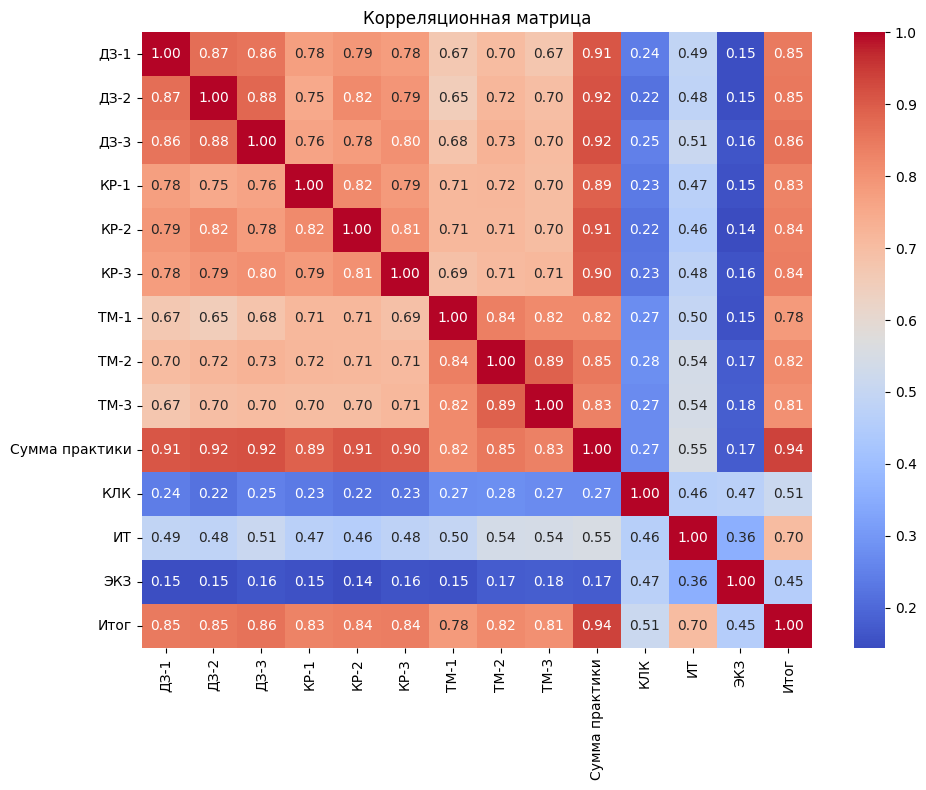

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(df_res[numeric_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляционная матрица")
plt.tight_layout()
plt.show()

### Видно, что экзамены (КЛК, ЭКЗ и ИТ) слабо коррелируют с итогом. Возможно, это связано с тем, что набрав необходимый порог за счет КР, ДЗ и ТМ, студенты решают не идти на экзамен, поэтому в графе стоит 0.

### **Сильные/слабые стороны каждого потока**

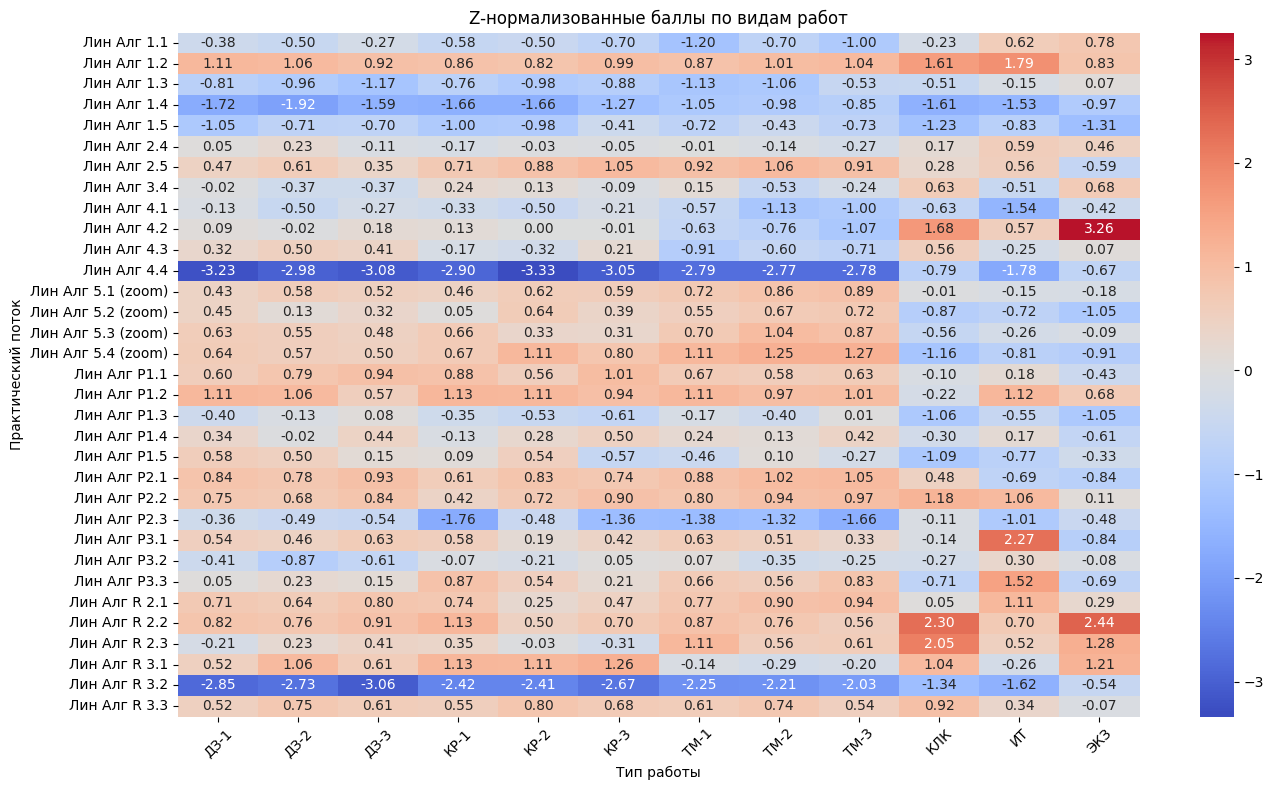

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

score_columns = ['ДЗ-1', 'ДЗ-2', 'ДЗ-3', 'КР-1', 'КР-2', 'КР-3', 'ТМ-1', 'ТМ-2', 'ТМ-3', 'КЛК', 'ИТ', 'ЭКЗ']
grouped = df_res.groupby("Практический поток")[score_columns].mean()

# нормализация по столбцам (z-score)
grouped_normalized = (grouped - grouped.mean()) / grouped.std()
plt.figure(figsize=(14, 8))
sns.heatmap(grouped_normalized, cmap="coolwarm", center=0, annot=True, fmt=".2f")
plt.title("Z-нормализованные баллы по видам работ")
plt.xlabel("Тип работы")
plt.ylabel("Практический поток")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



### Интересно, что таблицу можно четко разделить на две части. Например, отдельно рассмотреть ДЗ, КР и ТМ, а экзамены отдельно. Видим, что они по разному корреляируют с потоками.

### На экзаменах студенты находятся в более равных условиях, что может натолкнуть на мысли о несправедливом оценивании ДЗ, КР и ТМ в потоке 4.4. Да, результаты там ниже, но не настолько ужасно, как в оставшейся части таблицы.

### Интересно, что zoom потоки 5.X экзамен сдают в среднем хуже, чем очные потоки.

# **Вывод:**
## Статистические различия между потоками есть, причем довольно ощутимые. Особенно это видно на примере 4 лекционного потока, практических потоков 1.4, 4.4 и R 3.2